In [ ]:
%%bash
if ! conda env list | grep microexpressions; then
    conda env create -f environment.yml
else
    conda env update -f environment.yml
fi
conda activate microexpressions
dvc pull

In [ ]:
import sys
import os
PROJ_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJ_PATH)

Device: cpu


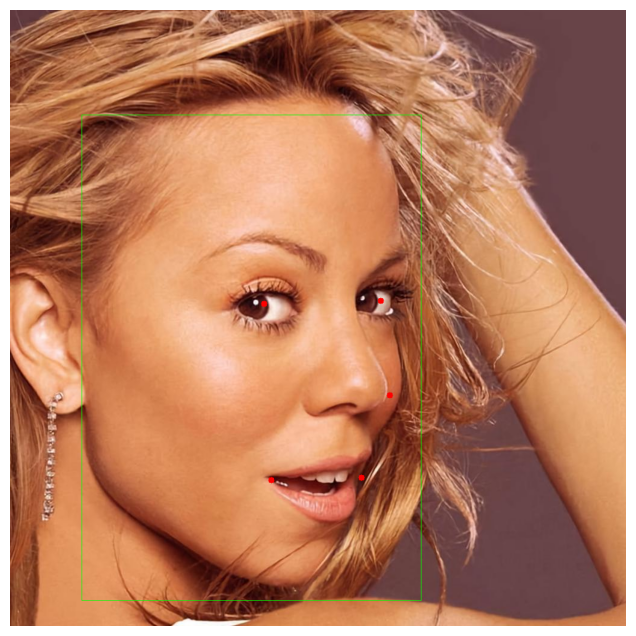

1.1128239536134044 0.07033751949064745


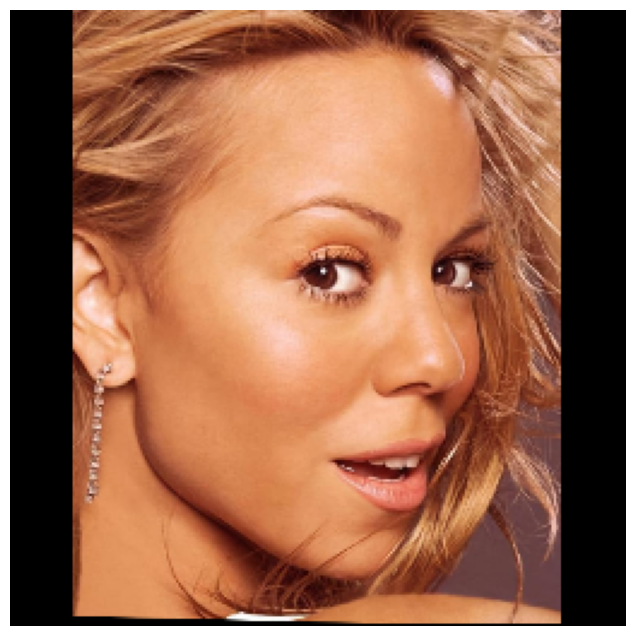

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.alignment import detect_faces, align_face

PROJ_PATH = os.getcwd()
DATA_DIR = os.path.join(PROJ_PATH, 'data')
MODEL_DIR = os.path.join(PROJ_PATH, 'models')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

image_path = os.path.join(DATA_DIR, "raw", r"celeba_hq", "006158.jpg")
model_path = os.path.join(MODEL_DIR, "yolov8n-face.pt")
image, detections = detect_faces(image_path, model_path, device)

source_image = image.copy()
for det in detections[:1]:
    x1, y1, x2, y2 = map(int, det["bbox"])
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    for x, y in det["landmarks"]:
        cv2.circle(image, (int(x), int(y)), 5, (0, 0, 255), -1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

aligned_image, yaw_norm, pitch_norm = align_face(source_image, np.array(detections[0]["landmarks"]), detections[0]["bbox"], output_size=(256, 256))
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
print(yaw_norm, pitch_norm)
plt.axis("off")
plt.show()

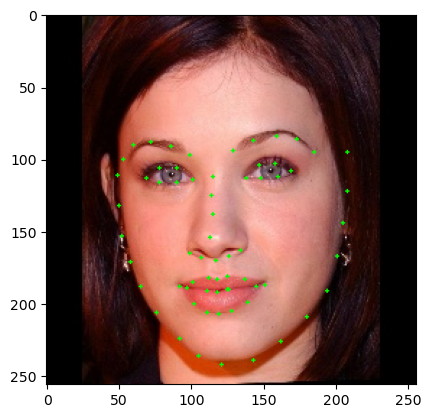

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from src.demo_helpers import plot_landmarks_cv2
import os
import cv2

df = pd.read_hdf(r"data\landmarks\lm_celeba_hq_pipnet.h5")
row = df.iloc[47]
filename = row["filename"]
image_path = os.path.join(r"data\processed\aligned_celeba_hq", filename)
plt.imshow(cv2.cvtColor(plot_landmarks_cv2(image_path, row), cv2.COLOR_BGR2RGB))

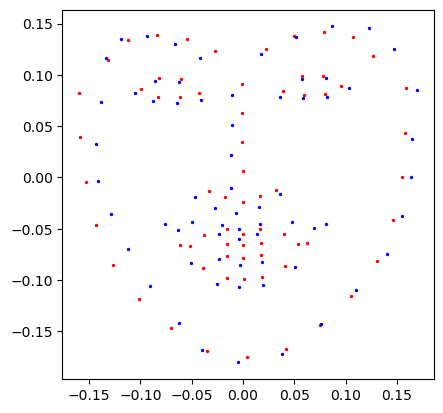

In [122]:
import numpy as np
from src.procrustes import *

meanface_file = r"models\meanface.txt"
with open(meanface_file) as f:
    meanface = f.readlines()[0]

meanface = meanface.strip().split()
meanface = [float(x) for x in meanface]
meanface = np.array(meanface).reshape(-1, 2)

meanface_n = normalize_reference(meanface)
df = pd.read_hdf(r"data\landmarks\pr_lm_celeba_hq_pipnet.h5")
row = df.iloc[6452]
landmarks = row[[ind for ind in row.index if re.match(r'(n_)?[xy]\d+', ind)]]
face = landmarks.to_numpy().reshape(-1, 2).astype(np.float32)

plt.scatter(meanface_n[:,0], -meanface_n[:, 1], c='red', s=2)
plt.scatter(face[:,0], -face[:, 1], c='blue', s=2)
plt.gca().set_aspect('equal')

In [1]:
from src.demo_helpers import plot_emb_with_images
import pandas as pd

viz_df = pd.read_hdf(r'data\landmarks\umap2_lm_celeba_hq_pipnet.h5')
lm_df = pd.read_hdf(r'data\landmarks\lm_celeba_hq_pipnet.h5')
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)

In [2]:
from src.extract_facial_features_and_filter import *

pr_lm_df = pd.read_hdf(r'data\landmarks\pr_lm_celeba_hq_pipnet.h5')
angles_filter = get_angles_filter(pr_lm_df)
viz_df['color'] = angles_filter
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)

e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [12]:
viz_df = viz_df[angles_filter]
lof_scores = get_local_outlier_factor(pr_lm_df, angles_filter, verbose=False)
viz_df['color'] = lof_scores < 1.15
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)

C:\Users\ymayma\AppData\Local\Temp\ipykernel_18444\1287260373.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [15]:
clusters = get_clusters(pr_lm_df, angles_filter, verbose=False)
values, counts = np.unique(clusters[clusters >= 0], return_counts=True)
main_cluster = values[counts.argmax()]
viz_df['color'] = (lof_scores < 1.15) & (clusters == main_cluster)
plot_emb_with_images(viz_df, lm_df, n_clusters=20, n_reps_per_cluster=2, random_state=2)


e:\Programs\miniconda\envs\microexpressions\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



['x0', 'x1']


In [174]:
from umap import UMAP
feat_df = pd.read_hdf(r"data\landmarks\features_celeba_hq_pipnet.h5")
X = feat_df.select_dtypes(include=['float64']).to_numpy()

umap = UMAP()
umap_cols = umap.fit_transform(X)

import plotly.express as px
umap_df = pd.DataFrame(umap_cols, columns = ['x1', 'x2'])
px.scatter(umap_df, x = 'x1', y = 'x2')